In [6]:
import anndata
import scipy.io
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy.api as sc
import glob
import os

import copy
sc.settings.set_figure_params(dpi=300)
sc.settings.verbosity = 3
import seaborn as sns

In [12]:
def calc_alignment(anndata, subset_group = None, subset_field = 'louvain', 
                   split_field = 'sample_name', n_pcs = 40, k = None, 
                   per_cell = False):
    """\
    Compute alignment metric between different batches, samples, etc.
    See Butler et al 2018 for derivation of this score. 
    Score should vary from 0 (low alignment) to 1 (high alignment)
    but in reality can exceed 1. 
    
    Parameters
    ----------
    subset_group
        If given, calculate only for cells in this group.
    subset_field
        Column in anndata.obs from which to take subset, if
        subset_group not None.
    split_field
        Column in anndata.obs on which to split into groups.
    n_pcs 
        Number of PCs to use in calculating nearest neighbors.
    k 
        Number of nearest neighbors to use in calculation of 
        per_cell alignment.
    per_cell
        Return np.ndarray of alignment score for each cell.
        Otherwise mean value.

    Returns
    -------
    Mean alignment score across cells, or array of scores 
    for each cell.
    """
    if subset_group is not None:
        anndata = anndata[anndata.obs[subset_field] == subset_group, :]
        # hack to convert view of anndata object into actual anndata object 
        # otherwise causes problems with concatenation
        anndata = sc.pp.subsample(anndata, fraction=1.0, copy=True)
    
    unique_groups = anndata.obs[split_field].unique()
    if len(unique_groups) == 1:
        print('Only one unique group for split_field provided.')
        return -1
    smallest = anndata.obs[split_field].value_counts().idxmin()
    min_cells = anndata.obs[split_field].value_counts()[smallest]
    if (min_cells < 2):
        print('Less than 2 cells for smallest group. Alignment not meaningful.')
        return -1
    
    downsampled = anndata[anndata.obs[split_field] == smallest, :]
    for group in unique_groups:
        if group != smallest:
            temp = anndata[anndata.obs[split_field] == group, :]
            temp = sc.pp.subsample(temp, n_obs = min_cells, copy=True)
            downsampled = downsampled.concatenate(temp)
    N = len(anndata.obs[split_field].unique())
    if downsampled.n_obs <= 30:
        max_cells = np.max(anndata.obs[split_field].value_counts())
        print('Total number of downsampled cells likely too small',
              'for meaningful alignment. ',
              ('Check proportion of {} groups instead. '
               'Smallest to largest: {}'.format(N, min_cells / float(max_cells))))
    min_pcs = min(downsampled.n_obs-1, n_pcs)
    sc.tl.pca(downsampled, svd_solver='arpack', n_comps=min_pcs)
    neighbors_obj = sc.Neighbors(downsampled)
    # TODO: better error checking
    if k is None:
        ratio = 20
        k = int(downsampled.n_obs / ratio)
    upper = 30
    lower = 3
    k = max(min(upper, k), lower)
    
    neighbors_obj.compute_neighbors(n_neighbors = k, n_pcs= min_pcs, 
                                    write_knn_indices=True)
    
    per_cell_alignment = np.zeros(downsampled.n_obs)
    for i, row in enumerate(neighbors_obj.knn_indices):
        # exclude same index (distance of 0)
        # TODO: this redundancy may be unintended in the scanpy code -- check
        use_row = row[row != i]
        num_same_group = sum(downsampled.obs[split_field][use_row] == downsampled.obs[split_field][i])
        # see original Seurat paper for derivation of this expression
        per_cell_alignment[i] =  1. - (num_same_group - (k / float(N))) / (k - k / float(N))
    
    if per_cell:
        return per_cell_alignment
    return np.mean(per_cell_alignment)

## Demonstrate alignment on V3 libraries

In [3]:
library_path = '/broad/macosko/data/libraries/'
# raw_feature_bc_matrix.h5 is specific to V3
v3_libs = glob.glob('{}*pBICCN*CB*/outs/raw_feature_bc_matrix.h5'.format(library_path), recursive = True)
v3_libs = [lib.split('/outs')[0] for lib in v3_libs]

In [7]:
# get 2 libraries to look at 
# for some reason, scanpy didn't retain gene information when reading h5 files -- TODO: look into this, maybe PR
for i in range(2):
    sample_adata_v3 = sc.read_10x_mtx(path='{}/outs/raw_feature_bc_matrix/'.format(v3_libs[i]), cache = True)
    sample_adata_v3.var_names_make_unique()
    sample_adata_v3.obs['sample_name'] = [v3_libs[i].split('/')[-1]]*sample_adata_v3.n_obs
                                                      
    sample_adata_v3.obs['cell_name'] = sample_adata_v3.obs.sample_name + '-' + sample_adata_v3.obs.index 
    sample_adata_v3.obs.index = sample_adata_v3.obs['cell_name'] 
    sample_adata_v3.obs['version'] = 'V3'

    sc.pp.filter_cells(sample_adata_v3, min_counts=800)

    if i == 0:
        adata_v3=sample_adata_v3

    if i > 0:
        adata_v3 = adata_v3.concatenate(sample_adata_v3)
    adata_v3_backup = copy.deepcopy(adata_v3)

... reading from cache file ./cache/broad-macosko-data-libraries-190111_pBICCNsMMrCBiVIIId190108b-outs-raw_feature_bc_matrix-matrix.h5ad
filtered out 6787529 cells that have less than 800 counts
... reading from cache file ./cache/broad-macosko-data-libraries-190111_pBICCNsMMrCBiVIIId190108a-outs-raw_feature_bc_matrix-matrix.h5ad
filtered out 6790930 cells that have less than 800 counts


In [8]:
adata_v3

AnnData object with n_obs × n_vars = 11301 × 27998 
    obs: 'batch', 'cell_name', 'n_counts', 'sample_name', 'version'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1'

In [10]:
adata_v3.obs['nUMI'] = adata_v3.X.sum(axis=1)
adata_v3.obs['log_nUMI'] = np.log(adata_v3.X.sum(axis=1))
adata_v3.obs['n_genes'] = np.count_nonzero(adata_v3.X.toarray(), axis=1)

sc.pp.log1p(adata_v3)
sc.pp.normalize_per_cell(adata_v3, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata_v3.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_v3 = adata_v3[:, filter_result.gene_subset]

sc.pp.log1p(adata_v3)
sc.pp.normalize_per_cell(adata_v3, counts_per_cell_after=1e4)

sc.pp.scale(adata_v3, max_value=10)
sc.tl.pca(adata_v3, svd_solver='arpack')

In [15]:
align1 = calc_alignment(adata_v3, split_field='sample_name')
# value higher than 1 indicates very high alignment 
align1

    using 'X_pca' with n_pcs = 40


1.0127004219409284

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:17.06) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:32.11) --> added
    'X_umap', UMAP coordinates (adata.obsm)


... storing 'sample_name' as categorical
... storing 'version' as categorical
... storing 'feature_types-0' as categorical
... storing 'feature_types-1' as categorical


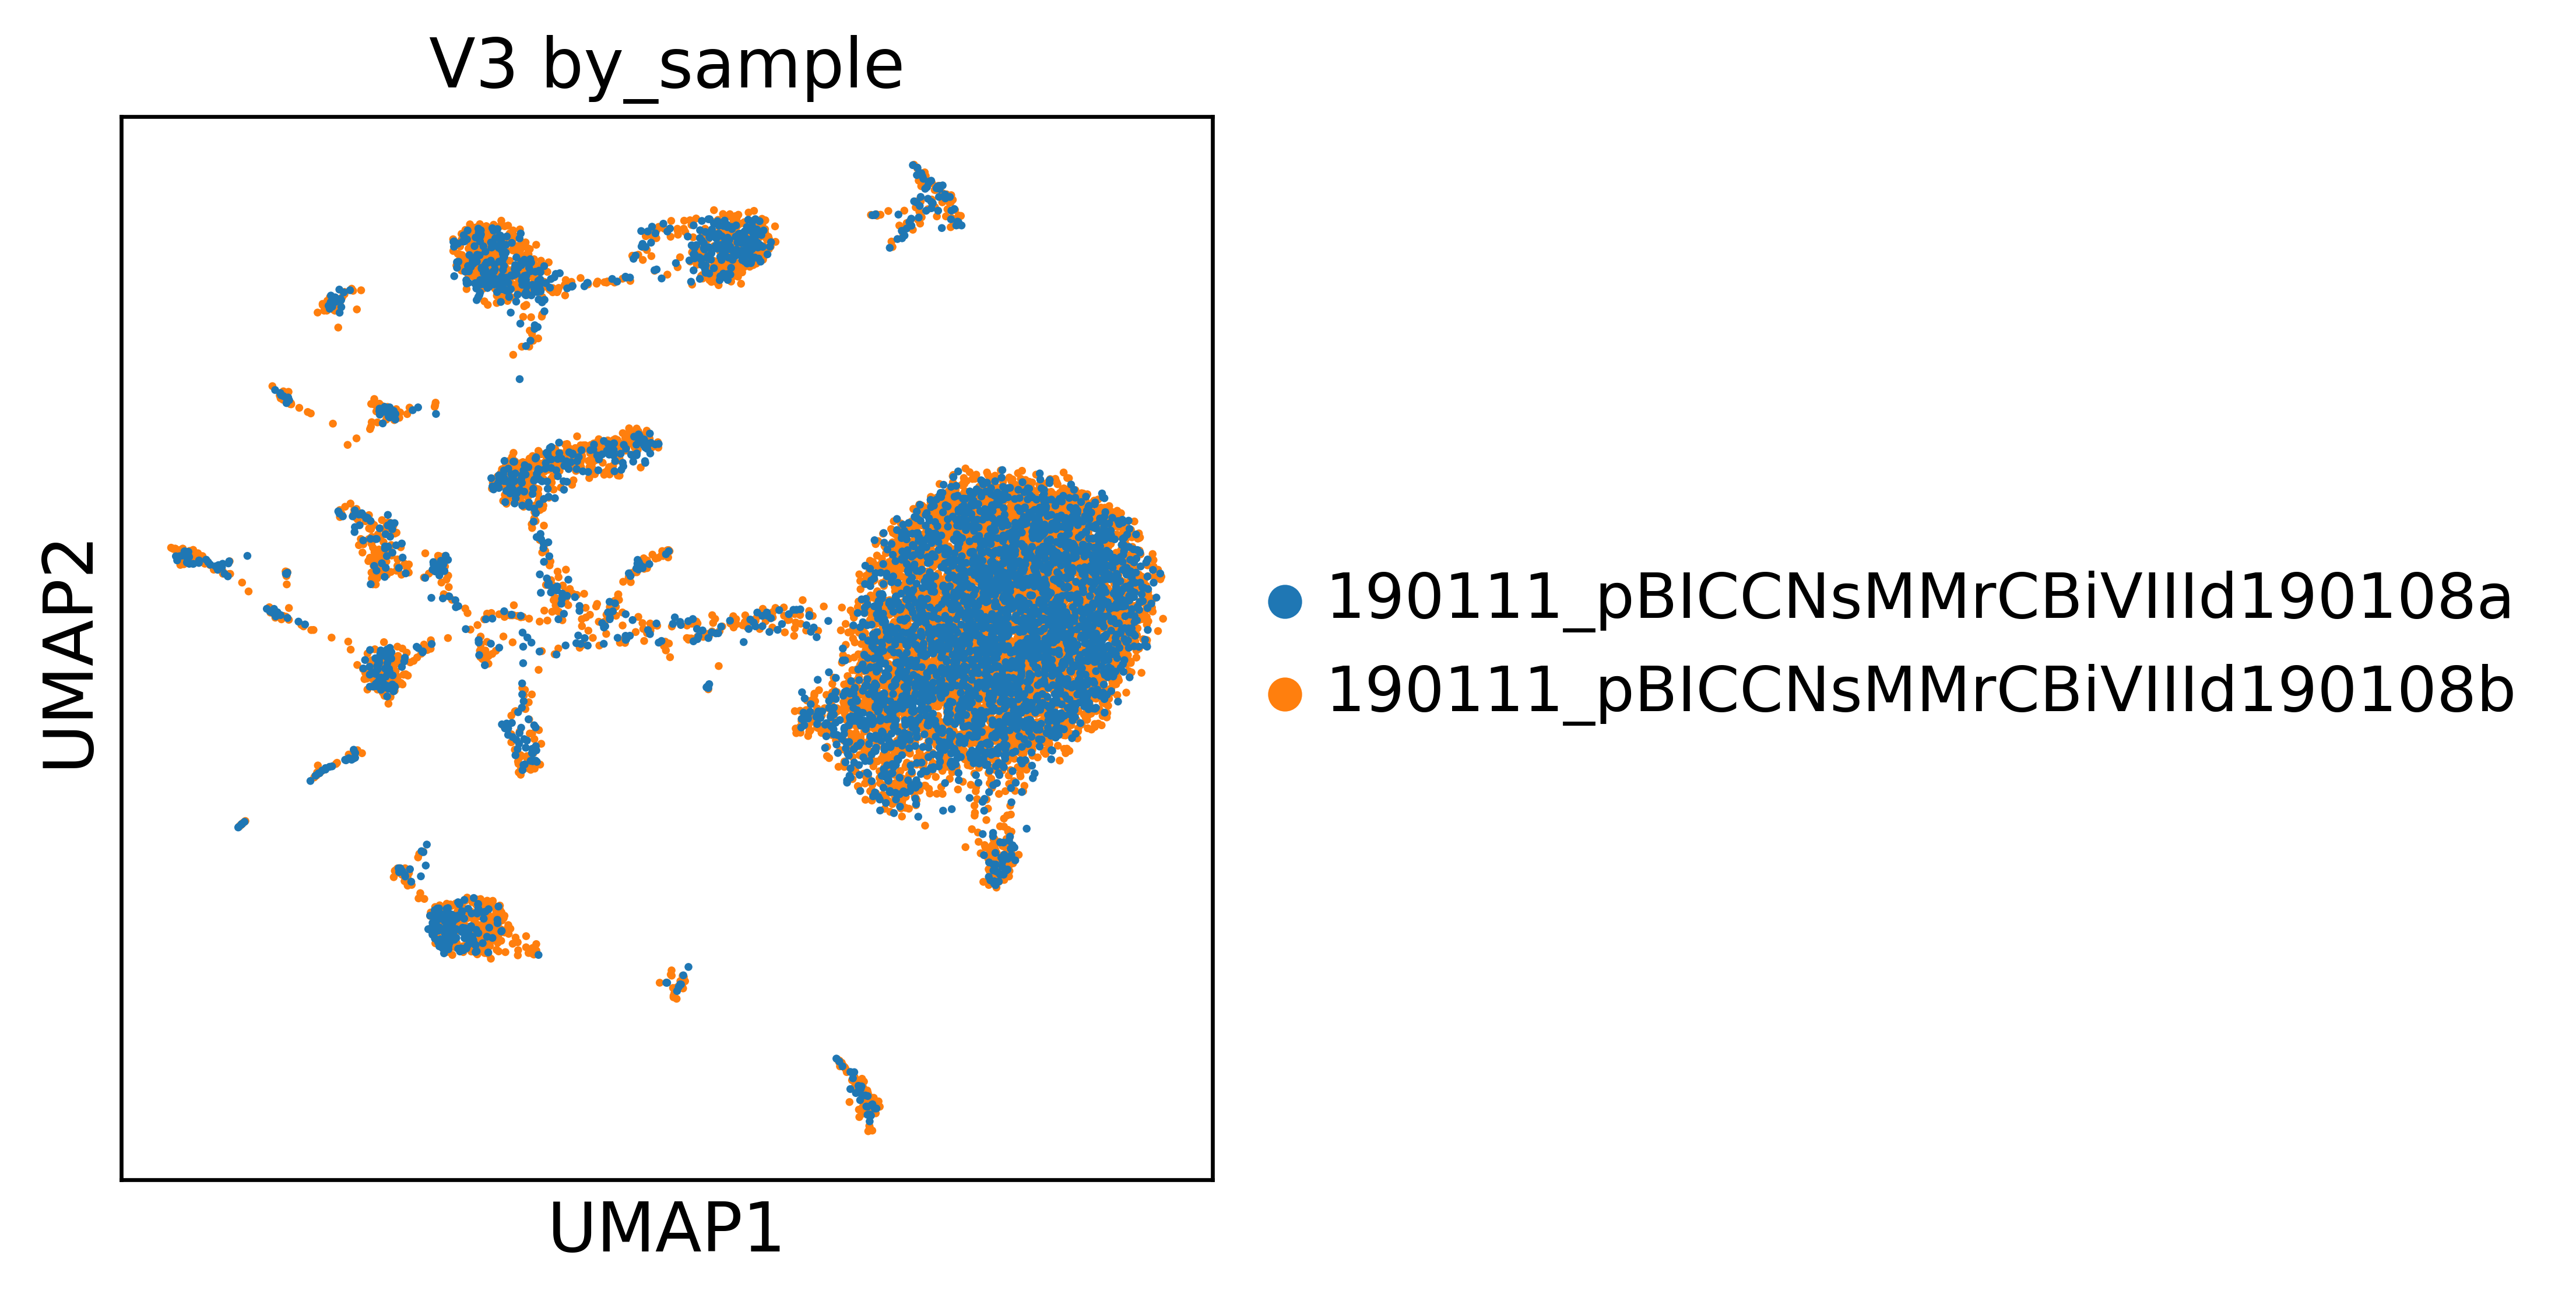

In [16]:
sc.pp.neighbors(adata_v3, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_v3)

#plt.hist(test_objaect.obs.n_counts , range=[0,1500])

sc.pl.umap(adata_v3, color=['sample_name'] , title=['V3 by_sample'])